In [1]:
!pip install -U tensorflow-text==2.6.0
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input
from transformers import BertTokenizer
from transformers import TFBertModel


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 28.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 54.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 10.6 MB/s eta 0:00:00
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77041 sha256=8609a417de43b4ffbf33ad5b93206b7433eb995d16b18d4cbae7860f9d9208c0
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.1
    Uninstalling wrapt-1.14.1:
      Successfully uninstalled wrapt-1.14.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
  Attempting uninstall: six
    Found existing installation

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [3]:
print(tokenizer.encode('My name is AbdulBasit',add_special_tokens=True,max_length=60))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[101, 2026, 2171, 2003, 10298, 22083, 4183, 102]


In [4]:
print(tf.__version__)

2.6.4


In [5]:
label_map={'severe':0, 'mild':1, 'no damage':2}

In [6]:
train_df=pd.read_csv('../input/datasettask3annotated/train-task3-annotated.csv')

In [7]:
train_df['image_path']=train_df.image_path.apply(lambda x: x.replace('\\','/'))
train_df['image_path']=train_df.image_path.apply(lambda x: f'../input/crisismmd/CrisisMMD_v2.0/data_image'+x)
train_df['damage_id']=train_df['damage'].apply(lambda x: label_map[x])

In [8]:
test_df=pd.read_csv('../input/datasettask3annotated/test-new-task3-annotated.csv')
test_df['image_path']=test_df.image_path.apply(lambda x: x.replace('\\','/'))
test_df['image_path']=test_df.image_path.apply(lambda x: f'../input/crisismmd/CrisisMMD_v2.0/data_image'+x)
test_df['damage_id']=test_df['damage'].apply(lambda x: label_map[x])
delete=[]
for idx,row in test_df.iterrows():
    if type(row['preprocess_tweet_text'])==float:
        test_df.at[idx,'preprocess_tweet_text']=' '
#test_df.drop(delete,inplace=True)
test_df

,Unnamed: 0,Unnamed: 0.1,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,...,image_damage,image_damage_conf,tweet_text,image_url,image_path,structure_type,preprocess_tweet_text,damage,structure,damage_id
0,18076,18076,9.100000e+17,910263603533664261_1,informative,0.6519,not_informative,1.0000,rescue_volunteering_or_donation_effort,0.6519,...,NaN,NaN,We delivered our relief efforts to Rockport to...,http://pbs.twimg.com/media/DKHn6lDU8AAjPW9.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,we delivered our relief effos to rockpo today ...,no damage,no structure,2
1,16144,16144,9.060000e+17,906262275392188416_0,informative,1.0000,not_informative,1.0000,rescue_volunteering_or_donation_effort,1.0000,...,NaN,NaN,4 of Edmond's finest helping with Harvey clean...,http://pbs.twimg.com/media/DJOwunEUEAUnF0h.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,4 of edmond finest helping with harvey cleanup,no damage,no structure,2
2,7759,7759,9.130000e+17,913045106847969281_0,informative,1.0000,informative,0.3409,rescue_volunteering_or_donation_effort,1.0000,...,NaN,NaN,"Christian Non-Profit Delivers 50,000 lbs Of Su...",http://pbs.twimg.com/media/DKvJrsAUQAAdtjf.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,christian non profit delivers 50 000 lbs of su...,no damage,no structure,2
3,16926,16926,9.070000e+17,907441230098952192_0,informative,1.0000,not_informative,0.6927,other_relevant_information,1.0000,...,NaN,NaN,Tornado watch extended in chatham county natio...,http://pbs.twimg.com/media/DJfg_U5XgAEmVcD.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,tornado watch extended in chatham county natio...,no damage,no structure,2
4,12631,12631,8.700000e+17,869957461993635840_0,informative,1.0000,informative,0.6587,rescue_volunteering_or_donation_effort,1.0000,...,mild_damage,0.7097,https://t.co/Z4mxTO7fpp Indian Navy carries ou...,http://pbs.twimg.com/media/DBK1s1nVoAELfTP.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/s...,others,,mild,no structure,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708,10164,10164,9.230000e+17,923361135268696064_2,informative,1.0000,informative,1.0000,rescue_volunteering_or_donation_effort,1.0000,...,NaN,NaN,"Thank you, @novak1016 , for transporting Westb...",http://pbs.twimg.com/media/DNBvvFTWAAAsq7s.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,thank you novak1016 for transpoing westbrook d...,no damage,no structure,2
2709,5143,5143,9.100000e+17,909949690552180736_0,informative,0.6702,informative,0.3595,other_relevant_information,0.6702,...,NaN,NaN,In Her Own Words: Nicole Matysik - 'Hurricane ...,http://pbs.twimg.com/media/DKDKUAVW4AAroPe.png,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,in her own words nicole matysik hurricane irma...,no damage,no structure,2
2710,15479,15479,9.050000e+17,905482831970873348_0,informative,0.6705,informative,0.5190,other_relevant_information,0.6705,...,NaN,NaN,The weight of Harveyâ€™s floodwater actually m...,http://pbs.twimg.com/media/DJDr1iUW4AQqyLI.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,the weight of harvey floodwater actually made ...,no damage,no structure,2
2711,12907,12907,8.710000e+17,870849885553045504_0,informative,1.0000,informative,1.0000,rescue_volunteering_or_donation_effort,1.0000,...,NaN,NaN,#CentralFinance provided medicine for the floo...,http://pbs.twimg.com/media/DBXhWldVwAIeNq5.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/s...,NaN,centralfinance provided medicine for the floo...,no damage,no structure,2


In [9]:
delete=[]
for idx,row in train_df.iterrows():
    if type(row['preprocess_tweet_text'])==float:
        train_df.at[idx,'preprocess_tweet_text']=' '
        #delete.append(idx)
#train_df.drop(delete,inplace=True)

In [10]:
train_df

,Unnamed: 0,Unnamed: 0.1,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,...,image_damage,image_damage_conf,tweet_text,image_url,image_path,structure_type,preprocess_tweet_text,damage,structure,damage_id
0,4716,4716,9.100000e+17,909880224631857152_0,informative,0.3519,informative,0.6850,rescue_volunteering_or_donation_effort,0.3519,...,little_or_no_damage,1.0000,"Restoration of Water Supply Benefits 25,000 Cu...",http://pbs.twimg.com/media/DKCLPZnUEAAjmfu.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,others,restoration of water supply benefits 25 000 cu...,no damage,no structure,2
1,3612,3612,9.100000e+17,909721023968432128_0,informative,0.6892,informative,1.0000,other_relevant_information,0.6892,...,NaN,NaN,RT @Thorcaster: Visible-like imagery in the mi...,http://pbs.twimg.com/media/DJ8zIoRVYAAmomo.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,visible like imagery in the middle of the nig...,no damage,no structure,2
2,6953,6953,9.120000e+17,911520559850287104_0,informative,1.0000,not_informative,0.6784,other_relevant_information,1.0000,...,NaN,NaN,RT @CBPCaribbean: #CBP is ready!! #PuertoRico ...,http://pbs.twimg.com/media/DKHTHLEVYAAN_gt.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,cbp is ready pueorico amp usvi please prepare...,no damage,no structure,2
3,15960,15960,9.060000e+17,905988543142653956_0,informative,0.5568,informative,1.0000,other_relevant_information,0.5568,...,severe_damage,1.0000,@DaveMustaine Oh I'm so sorry I just went trou...,http://pbs.twimg.com/media/DJK3xk3VAAA0M3n.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,buildings,davemustaine oh so sorry just went trough har...,severe,building,0
4,1580,1580,9.300000e+17,930074444151869440_0,informative,1.0000,informative,1.0000,other_relevant_information,1.0000,...,NaN,NaN,RT @YerevanSaeed: According to earthquake info...,http://pbs.twimg.com/media/DOc_wv3W0AA0rz6.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/i...,NaN,according to eahquake info 7 2 eahquake hits ...,no damage,no structure,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15364,3421,3421,9.090000e+17,909492362581282816_2,informative,0.5123,informative,1.0000,infrastructure_and_utility_damage,0.5123,...,little_or_no_damage,0.6774,HEART 911 Hurricane Irma Response Team 2 is in...,http://pbs.twimg.com/media/DJ8qe5QUIAAGepx.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,others,hea 911 hurricane irma response team 2 is in s...,no damage,no structure,2
15365,15418,15418,9.050000e+17,905433688367816708_0,not_informative,1.0000,not_informative,0.6678,not_humanitarian,1.0000,...,NaN,NaN,Harvey Nash: HR Business Partner https://t.co/...,http://pbs.twimg.com/media/DJC_I8lUEAEhmXE.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,harvey nash hr business paner,no damage,no structure,2
15366,17704,17704,9.090000e+17,908820242381529088_0,informative,1.0000,informative,1.0000,other_relevant_information,1.0000,...,NaN,NaN,Blue Tide Aquatics Heals From Harvey Through S...,http://pbs.twimg.com/media/DJzHMUsUQAAT-kU.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,blue tide aquatics heals from harvey through s...,no damage,no structure,2
15367,4388,4388,9.100000e+17,909831938877329409_0,not_informative,0.6909,not_informative,1.0000,not_humanitarian,0.6909,...,NaN,NaN,RT @Ih8ghettobarbi3: Ass On Irma Ὂ6ἵ1 https://...,http://pbs.twimg.com/media/DJcrH3bW0AARxQL.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,NaN,ass on irma 6 1,no damage,no structure,2


In [11]:
train_df['tokenised_text']=train_df['preprocess_tweet_text'].apply(lambda x:tokenizer.encode(x, add_special_tokens=True, max_length=60) )

In [12]:
test_df['tokenised_text']=test_df['preprocess_tweet_text'].apply(lambda x:tokenizer.encode(x, add_special_tokens=True, max_length=60) )

In [13]:
max_len = 60
#input_ids_train=[]
#for i in train_df['tokenised_text'].values:
#    input_ids_train.append(tf.constant(i+[0]*(max_len-len(i))))
input_ids_train= np.array([i + [0]*(max_len-len(i)) for i in train_df['tokenised_text'].values])
attention_mask_train= np.where(input_ids_train!= 0, 1, 0)
'''attention_mask_train=[]
for row in input_ids_temp:
    temp=[]
    for val in row:
        if val!=0:
            temp.append(1)
        else:
            temp.append(0)
    attention_mask_train.append(tf.constant(temp))'''

'attention_mask_train=[]\nfor row in input_ids_temp:\n    temp=[]\n    for val in row:\n        if val!=0:\n            temp.append(1)\n        else:\n            temp.append(0)\n    attention_mask_train.append(tf.constant(temp))'

In [14]:
max_len = 60
input_ids_test= np.array([i + [0]*(max_len-len(i)) for i in test_df['tokenised_text'].values])
attention_mask_test= np.where(input_ids_test!= 0, 1, 0)

In [15]:
def dataframe_to_dataset(dataframe,input_ids,attention_mask,training=True):
    columns = ["image_path", "damage_id"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("damage_id")
    label_array=[]
    for i in labels:
        temp=[0,0,0]
        temp[i]=1
        label_array.append(temp)
    ds = tf.data.Dataset.from_tensor_slices((dataframe['image_path'],input_ids,attention_mask, label_array))
    if training:
        ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [16]:
resize = (384, 384)


def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]
    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image

'''
def preprocess_text(text_1):
    text_1 = tf.convert_to_tensor([text_1])
    output = bert_preprocess_model(text_1)
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output'''


def preprocess_text_and_image(sample,input_ids,attention_mask):
    image_1 = preprocess_image(sample)
    text_1={
        'input_ids':input_ids,
        'attention_mask':attention_mask
    }
    return {"image": image_1, "text": text_1}

In [17]:
batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe,input_ids,attention_mask, training=True):
    ds = dataframe_to_dataset(dataframe,input_ids,attention_mask,training)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x,input_ids,attention_mask, y: (preprocess_text_and_image(x,input_ids,attention_mask), y))
    ds = ds.batch(batch_size)
    return ds


train_ds = prepare_dataset(train_df,input_ids_train,attention_mask_train)


2022-06-13 00:28:59.415394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 00:28:59.416649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 00:28:59.417521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 00:28:59.420433: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
test_ds = prepare_dataset(test_df,input_ids_test,attention_mask_test,training=False)


In [19]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [31]:
deit=keras.models.load_model('../input/deit-distilled')
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    # Set the trainability of the base encoder.
    
    # Receive the images as inputs.
    deit.trainable=False
    image_1 = keras.Input(shape=(384, 384 ,3), name="image")
    x = tf.keras.layers.RandomFlip(mode='horizontal_and_vertical')(image_1)
    x = tf.keras.layers.RandomRotation(0.1)(x)
    x=tf.keras.layers.RandomHeight(factor=0.1)(x)
    x=tf.keras.layers.RandomWidth(0.1)(x)
    x = tf.keras.layers.RandomZoom(0.2)(x)
    # Preprocess the input image.
    preprocessed_1 = tf.keras.layers.Rescaling(1./255)(x)
    preprocessed_1=tf.keras.layers.Resizing(384,384)(preprocessed_1)
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings_1= deit(preprocessed_1)[0]
    # Project the embeddings produced by the model
    outputs =project_embeddings(
        embeddings_1, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(image_1, outputs, name="vision_encoder")

In [32]:
bert=TFBertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_ids", "attention_mask"]
    inputs = {
        feature: keras.Input(shape=(60,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert.bert(inputs['input_ids'], attention_mask=inputs['attention_mask'])[0][:,0,:]
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )

    # Project the embeddings produced by the model.
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


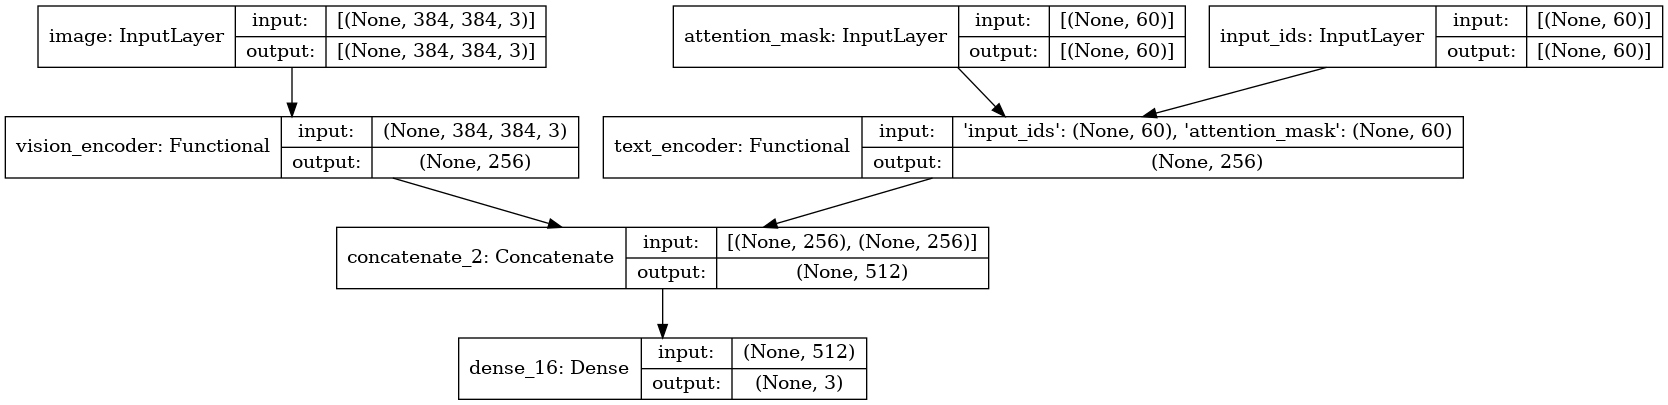

In [33]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(384, 384, 3), name="image")

    # Receive the text as inputs.
    bert_input_features = ["input_ids", "attention_mask"]
    text_inputs = {
        feature: keras.Input(shape=(60,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, 256, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, 256, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder(image_1)
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(3, activation="softmax")(concatenated)
    return keras.Model([image_1, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [34]:
multimodal_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
vision_encoder (Functional)     (None, 256)          86355200    image[0][0]                      
____________________________________________________________________________________________

In [ ]:
tf.get_logger().setLevel('INFO')
loss=tf.keras.losses.CategoricalCrossentropy()
metrics = METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precison"),
    tf.keras.metrics.Recall(name="recall")
]
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(amsgrad=True), loss=loss, metrics=metrics
)
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=8)
mc = keras.callbacks.ModelCheckpoint('best_model_alt-loss-multi-deit', monitor='recall', mode='max', save_best_only=True)
ms = keras.callbacks.ModelCheckpoint('best_model_alt-valloss-multi-deit', monitor='val_recall', mode='max', save_best_only=True)
callbacks_list = [es, mc,ms] #early
class_weights={0:7.4,1:20.2,2:1.23}
history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=100,callbacks=callbacks_list,class_weight=class_weights)

In [ ]:
i=0
while i==0:
    x=0

In [36]:
history=multimodal_model.history

In [53]:
import time
start=time.time()
predict=multimodal_model.predict(test_ds)
prediction=[]
for row in predict:
    prediction.append(np.argmax(row))

finish=time.time()
print(f'time elapsed {finish-start}')

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


time elapsed 75.92737603187561


In [54]:
real=test_df['damage_id']

In [55]:
from sklearn import metrics
print(metrics.classification_report(real,prediction))
print(metrics.confusion_matrix(real,prediction))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       503
           1       0.64      0.82      0.72       229
           2       0.97      0.94      0.95      2217

    accuracy                           0.90      2949
   macro avg       0.80      0.85      0.82      2949
weighted avg       0.91      0.90      0.91      2949

[[ 392   52   59]
 [  28  187   14]
 [  76   52 2089]]


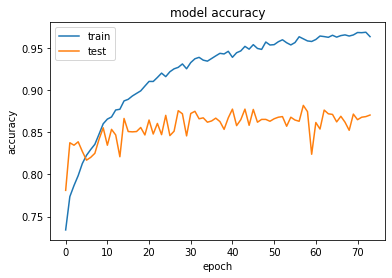

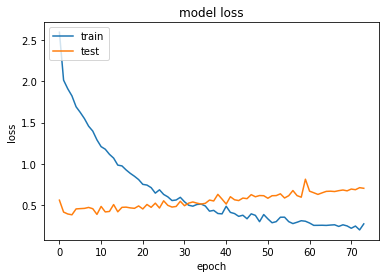

In [37]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

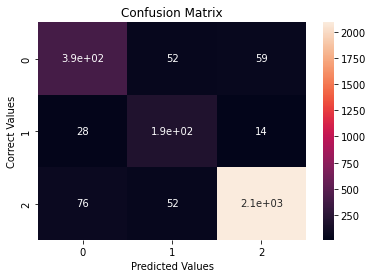

In [56]:
import seaborn as sns
cm = metrics.confusion_matrix(real, prediction)

sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Correct Values')
plt.xlabel('Predicted Values')
plt.show()

In [51]:
import shutil
shutil.make_archive('task3-image-multmodal-singleoutput-deit-bert-severity', 'zip', './best_model_alt-loss-multi-deit')
shutil.make_archive('task3-image-val-mutlimodal-singleoutput-deit-bert-severity', 'zip', './best_model_alt-valloss-multi-deit')

'/kaggle/working/task3-image-val-mutlimodal-singleoutput-deit-bert-severity.zip'